In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch_scatter as scatter
import yaml
from models.sc_net import SCnet,GNN,CoordiNet
import sys
import torch.nn.functional as F
import pickle
sys.path.append('..')
from dataset.tmQM_data import tmQM_wrapper,tmQM_dataset
import torch_geometric.nn as nn
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [2]:
config = yaml.load(open("./config.yaml", "r"), Loader=yaml.FullLoader)

In [3]:
with open(config['path']['complex'],'rb') as f:
    complexes = pickle.load(f)

In [4]:
def euclidean_distances(x, y, squared=True):
    """Compute pairwise (squared) Euclidean distances.
    """
    assert isinstance(x, np.ndarray) and x.ndim == 2
    assert isinstance(y, np.ndarray) and y.ndim == 2
    assert x.shape[1] == y.shape[1]

    x_square = np.sum(x*x, axis=1, keepdims=True)
    if x is y:
        y_square = x_square.T
    else:
        y_square = np.sum(y*y, axis=1, keepdims=True).T
    distances = np.dot(x, y.T)
    # use inplace operation to accelerate
    distances *= -2
    distances += x_square
    distances += y_square
    # result maybe less than 0 due to floating point rounding errors.
    np.maximum(distances, 0, distances)
    if x is y:
        # Ensure that distances between vectors and themselves are set to 0.0.
        # This may not be the case due to floating point rounding errors.
        distances.flat[::distances.shape[0] + 1] = 0.0
    if not squared:
        np.sqrt(distances, distances)
    return distances

In [61]:
pcas = []
xyzs = []
for i in range(1000):
    dist = complexes[i]['dist']
    transformer = KernelPCA(3,kernel='rbf')
    pca = transformer.fit_transform(dist).reshape(1,-1).squeeze()
    pca = np.pad(pca,(0,1800-pca.shape[0]),'constant')
    pcas.append(pca)
    xyz = np.array(complexes[i]['xyz']).reshape(1,-1).squeeze()
    xyz = np.pad(xyz,(0,1800-xyz.shape[0]),'constant')
    xyzs.append(xyz)
    if (i+1)%1000 == 0:
        print(f'{i+1} have finished!')

1000 have finished!


In [62]:
xyzs = np.array(xyzs)
pcas = np.array(pcas)

In [63]:
pcas.shape

(1000, 1800)

In [64]:
from sklearn.manifold import TSNE
tsne1 = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=10)
tsne2 = TSNE(n_components=2, learning_rate='auto',
                   init='pca', perplexity=10)
v1= tsne1.fit_transform(xyzs)
v2= tsne2.fit_transform(pcas)

In [68]:
xyzs.shape

(1000, 1800)

In [66]:
def label_point(x, y, val, ax):
    for i in range(len(val)):
        ax.text(x[i]+0.5, y[i], str(val[i]))

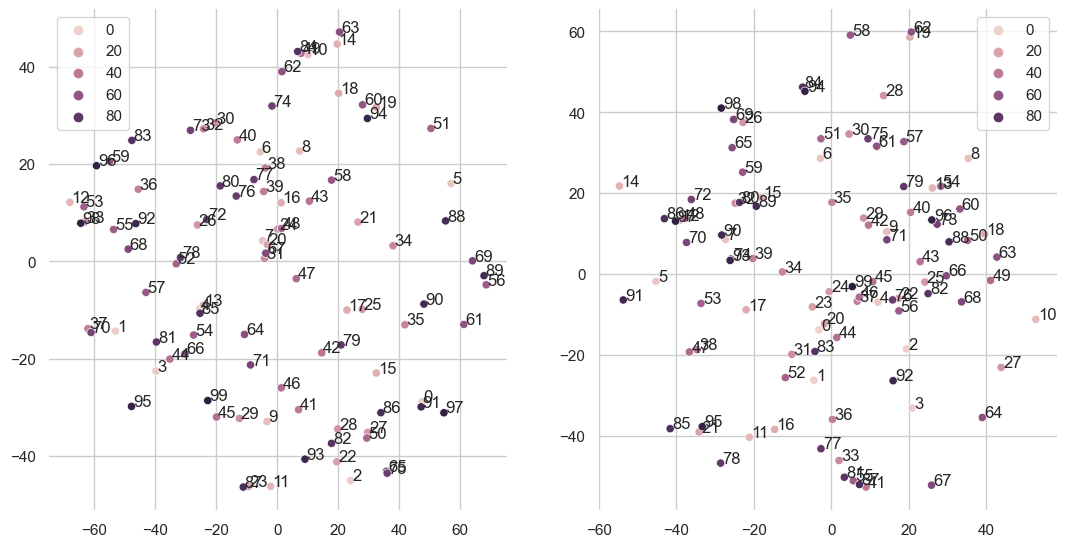

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Draw a scatter plot while assigning point colors and sizes to different
# variables in the dataset
f, axes = plt.subplots(1,2,figsize=(13, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=v1,x=v1[:100,0],y=v1[:100,1],ax=axes[0],hue=list(range(100)))
sns.scatterplot(data=v2,x=v2[:100,0],y=v2[:100,1],ax=axes[1],hue=list(range(100)))
label_point(v1[:100,0],v1[:100,1],list(range(100)),axes[0])
label_point(v2[:100,0],v2[:100,1],list(range(100)),axes[1])

In [74]:
xyz[:,0].shape

(116,)

In [10]:
from sklearn.manifold import TSNE
tsne1 = TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )
vs1 = tsne1.fit_transform(xyzs)


: 

: 

In [93]:

dist1 = complexes[0]['dist']
dist2 = complexes[1]['dist']
# transformer1 = KernelPCA(n_components=2, kernel='cosine')
dist = []
transformer1 = PCA(3)
transformer2 = PCA(3)
transformer1 = transformer1.fit(dist1)
transformer2 = transformer2.fit(dist2)
td1 = transformer1.transform(dist1)
td2 = transformer2.transform(dist2)

In [96]:
vras = []
for i in range(1000):
    dist = complexes[i]['dist']
    transformer = PCA(3)
    transformer = transformer1.fit(dist) 
    vra = transformer.explained_variance_ratio_
    vras.append(vra)

In [95]:
transformer2.explained_variance_ratio_

array([0.49383133, 0.29560696, 0.13371554])

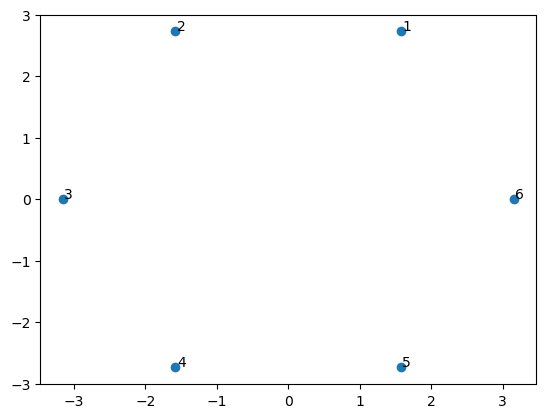

In [73]:
x = X_transformed1[:,0]
y = X_transformed1[:,1]
plt.scatter(x,y)
txt = ['1','2','3','4','5','6']
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.02, y[i]+0.02))

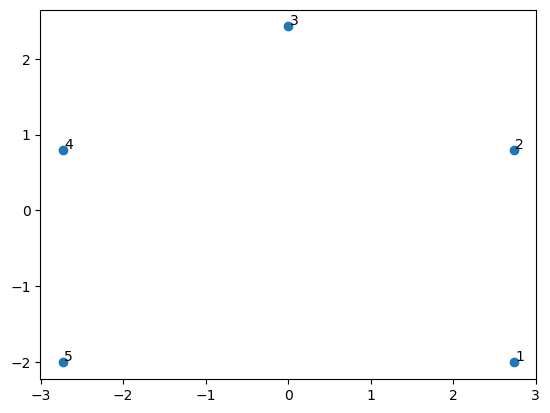

In [74]:
x = X_transformed2[:,0]
y = X_transformed2[:,1]
plt.scatter(x,y)
txt = ['1','2','3','4','5','6']
for i in range(len(x)):
    plt.annotate(txt[i], xy = (x[i], y[i]), xytext = (x[i]+0.02, y[i]+0.02))

In [134]:
dist2

array([[0.        , 2.        , 3.46407621, 3.999912  , 3.464     ],
       [2.        , 0.        , 1.999956  , 3.464     , 3.999912  ],
       [3.46407621, 1.999956  , 0.        , 1.999956  , 3.46407621],
       [3.999912  , 3.464     , 1.999956  , 0.        , 2.        ],
       [3.464     , 3.999912  , 3.46407621, 2.        , 0.        ]])

In [3]:
dataset = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],**config['data'])
train,valid,test = dataset.get_data_loaders()

In [16]:
model = SCnet(
    GNN_config=config['GNN'],
    Coor_config=config['Coor_config'],
    out_dimention=config['out_dimention'],
    separated=config['separated'],
)
model1 = GNN(**config['GNN'])
model2 = CoordiNet(**config['Coor_config'])

In [4]:
iteration = iter(train)
BatchData = next(iteration)
x = BatchData.x
batch = BatchData.batch
index = BatchData.edge_index
metal = BatchData.metal

In [5]:
graph = BatchData[0]

In [6]:
graph

Data(x=[68, 601], edge_index=[2, 142], edge_attr=[284], node_split=[2], metal=[18], y=[8])

In [2]:
import matplotlib.pyplot as plt

In [3]:
mean = np.array([2948.5,0.14095,5.7493,0.15659,0.10936,0.19877,0.089408,393.36])
std = np.array([1624.2,0.069491,3.8897,0.79056,0.03385,0.054267,0.055114,151.05])

In [15]:
path = './experiment/entire/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
ent_mean = np.average(data/mean,axis=0)
ent_std = np.std(data/mean,axis=0)

In [16]:
path = './experiment/diffpool-32/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
diff32_mean = np.average(data/mean,axis=0)
diff32_std = np.std(data/mean,axis=0)

In [17]:
path = './experiment/NoAttention/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
noa_mean = np.average(data/mean,axis=0)
noa_std = np.std(data/mean,axis=0)

In [18]:
path = './experiment/No-atten-metal/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
noam_mean = np.average(data/mean,axis=0)
noam_std = np.std(data/mean,axis=0)

In [22]:
x = np.array(list(range(1,9)))

<ErrorbarContainer object of 3 artists>

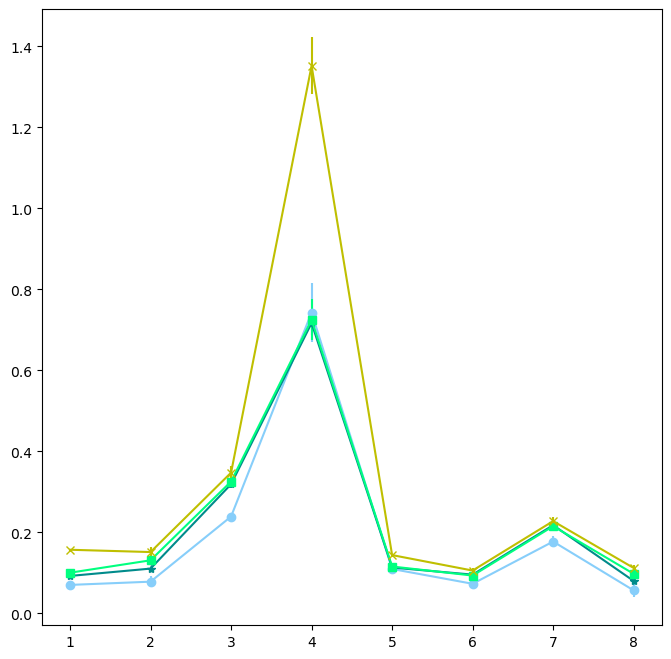

In [34]:
fig = plt.figure(figsize=(8,8))
plt.errorbar(x,ent_mean,ent_std,ecolor='lightskyblue',fmt='-o',color='lightskyblue')
plt.errorbar(x,diff32_mean,diff32_std,ecolor='darkcyan',fmt='-*',color='darkcyan')
plt.errorbar(x,noa_mean,noa_std,ecolor='springgreen',fmt='-s',color='springgreen')
plt.errorbar(x,noam_mean,noam_std,ecolor='y',fmt='-x',color='y')

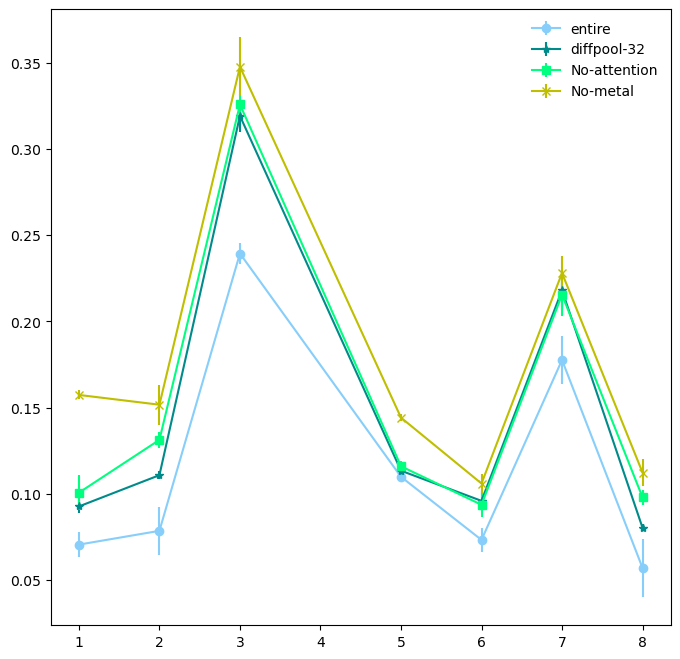

In [38]:
fig = plt.figure(figsize=(8,8))
x = np.array([1,2,3,5,6,7,8])
plt.errorbar(x,ent_mean[x-1],ent_std[x-1],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='entire')
plt.errorbar(x,diff32_mean[x-1],diff32_std[x-1],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.errorbar(x,noa_mean[x-1],noa_std[x-1],ecolor='springgreen',fmt='-s',color='springgreen',label='No-attention')
plt.errorbar(x,noam_mean[x-1],noam_std[x-1],ecolor='y',fmt='-x',color='y',label='No-metal')
plt.legend(frameon=False)

In [47]:
path = './experiment/diffpool_16/result.csv'
data = pd.read_csv(path,index_col=0).to_numpy()
diff16_mean = data[5,:]/mean
diff16_std = data[6,:]/mean

In [49]:
path = './experiment/diffpool_64/result.csv'
data = pd.read_csv(path,index_col=0).to_numpy()
diff64_mean = data[5,:]/mean
diff64_std = data[6,:]/mean

In [50]:
path = './experiment/topk-0.5/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
topk_mean = np.average(data/mean,axis=0)
topk_std = np.std(data/mean,axis=0)

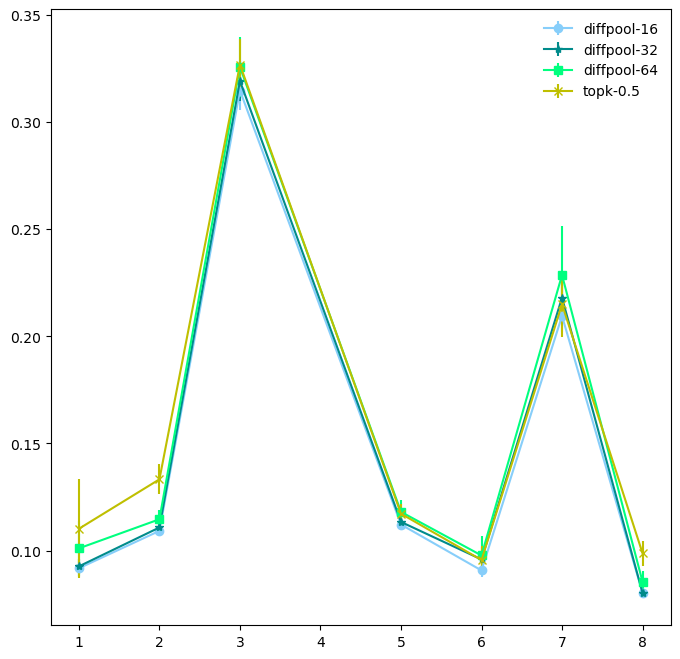

In [51]:
fig = plt.figure(figsize=(8,8))
x = np.array([1,2,3,5,6,7,8])
plt.errorbar(x,diff16_mean[x-1],diff16_std[x-1],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='diffpool-16')
plt.errorbar(x,diff32_mean[x-1],diff32_std[x-1],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.errorbar(x,diff64_mean[x-1],diff64_std[x-1],ecolor='springgreen',fmt='-s',color='springgreen',label='diffpool-64')
plt.errorbar(x,topk_mean[x-1],topk_std[x-1],ecolor='y',fmt='-x',color='y',label='topk-0.5')
plt.legend(frameon=False)

In [73]:
for i in [0.2,0.4,0.6]:
    path = f'./experiment/trainNoA_{str(i)}/result.csv'
    data = pd.read_csv(path,index_col=0).to_numpy()
    temp_mean = data[5,:]/mean
    temp_std = data[6,:]/mean
    if i == 0.2:
        trainNoa_mean = temp_mean[np.newaxis,:]
        trainNoa_std = temp_std[np.newaxis,:]
    else:
        trainNoa_mean = np.append(trainNoa_mean,temp_mean[np.newaxis,:],axis=0)
        trainNoa_std = np.append(trainNoa_std,temp_std[np.newaxis,:],axis=0)
path = './experiment/NoAttention/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
temp_mean = np.average(data/mean,axis=0)
temp_std = np.std(data/mean,axis=0)
trainNoa_mean = np.append(trainNoa_mean,temp_mean[np.newaxis,:],axis=0)
trainNoa_std = np.append(trainNoa_std,temp_std[np.newaxis,:],axis=0)

In [77]:
for i in [0.2,0.4,0.6]:
    path = f'./experiment/trainAtt_{str(i)}/result.csv'
    data = pd.read_csv(path,index_col=0).to_numpy()
    temp_mean = data[5,:]/mean
    temp_std = data[6,:]/mean
    if i == 0.2:
        trainAtt_mean = temp_mean[np.newaxis,:]
        trainAtt_std = temp_std[np.newaxis,:]
    else:
        trainAtt_mean = np.append(trainAtt_mean,temp_mean[np.newaxis,:],axis=0)
        trainAtt_std = np.append(trainAtt_std,temp_std[np.newaxis,:],axis=0)
path = './experiment/diffpool-32/result.csv'
data = pd.read_csv(path,header=None).to_numpy()
temp_mean = np.average(data/mean,axis=0)
temp_std = np.std(data/mean,axis=0)
trainAtt_mean = np.append(trainAtt_mean,temp_mean[np.newaxis,:],axis=0)
trainAtt_std = np.append(trainAtt_std,temp_std[np.newaxis,:],axis=0)

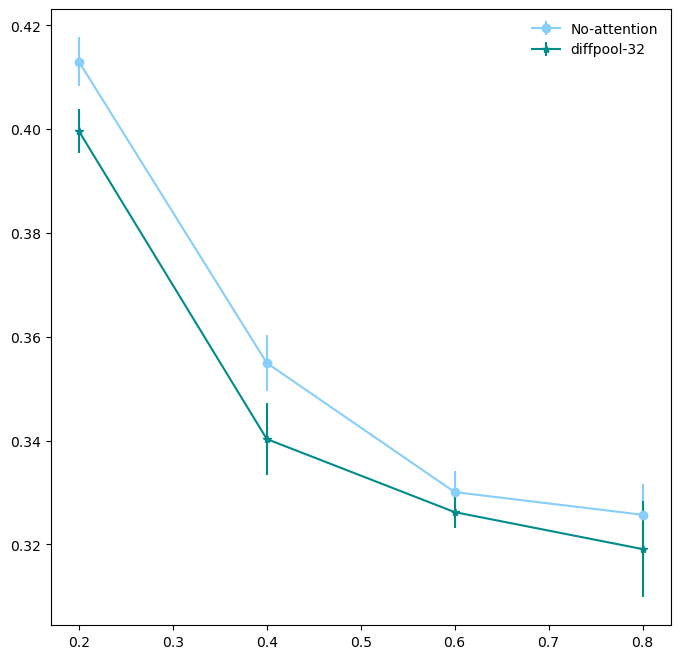

In [82]:
fig = plt.figure(figsize=(8,8))
target = 2
x = np.array([0.2,0.4,0.6,0.8])
plt.errorbar(x,trainNoa_mean[:,target],trainNoa_std[:,target],ecolor='lightskyblue',fmt='-o',color='lightskyblue',label='No-attention')
plt.errorbar(x,trainAtt_mean[:,target],trainAtt_std[:,target],ecolor='darkcyan',fmt='-*',color='darkcyan',label='diffpool-32')
plt.legend(frameon=False)